# Probleme
- Ellbogen wird nicht mitgespiegelt, Distanz Hand-Ellbogen links kann somit nicht mit relocated-Daten berechnet werden, sondern muss mit truncated-Daten berechnet werden. 
- Diese sind allerdings noch nicht prefiltered
Lösung: Präfilterung nach Truncation??

# 0. Raw-Umbenennung
Benennt die Dateien in einheitliche Namen um, Ausgangspunkt müssen dazu die "takeover"-Namen sein (darf nicht mehrmals ausgeführt werden).
Fehlerhafte Datumsangaben werden korrigiert.

In [1]:
import os, sys, math, pandas as pd, numpy as np, shutil

In [3]:
files = os.listdir('../DATA/0_raw')

for file in files:
    fileNumber = file.split("_takeover",1)[0]
    if len(fileNumber) > 12: #dont repeat script
        break
    
    year = fileNumber[0:4]
    if year != '2020' and year != '2021':
        fileNumber = fileNumber.replace(year,'2020',1)
    
    if file.find("RGraspPhase") != -1:
        side="R"
    else:
        side="L"
        
    oldpath = r'../DATA/0_raw/'+file
    newpath = r'../DATA/0_raw/'+str(fileNumber)+'_raw_'+side+'.csv'
    os.rename(oldpath,newpath)

# 1. Interpolation
Momentan lineare Interpolation für bis zu 2 NaNs, andere Methoden denkbar. Erstellt neue csv-Dateien im interpolated-Ordner.

array([[<AxesSubplot:title={'center':'Dateilängen'}>]], dtype=object)

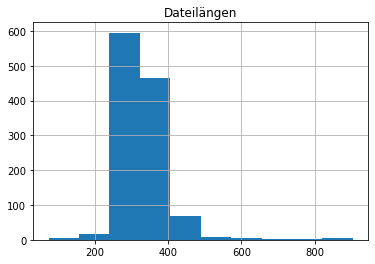

In [3]:
import os, sys, math, pandas as pd, numpy as np, shutil
files = os.listdir('../DATA/0_raw')

length_of_file = {}

for file in files:
    df = pd.read_csv('../DATA/0_raw/'+file, sep = ';') 
    interpolated_df = df.interpolate(method='linear',limit=2,limit_area='inside') 
    fileNumber = file.split("_raw",1)[0]
    side = file[-5]
    filename = '../DATA/1_interpolated/'+str(fileNumber)+'_interpolated_'+side+'.csv'
    interpolated_df.to_csv(filename, sep = ';', float_format='%.4f', na_rep='NaN', index=False)
    length_of_file.update({filename:len(interpolated_df)})

pd.DataFrame({"Dateilängen": list(length_of_file.values())}).hist()

array([[<AxesSubplot:title={'center':'Dateilängen'}>]], dtype=object)

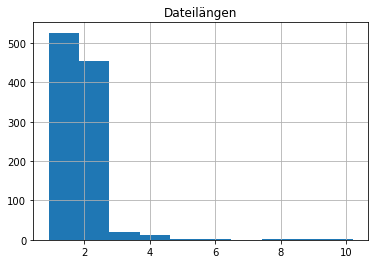

In [36]:
length_of_file = {}

for file in os.listdir('../DATA/3_truncated'):
    df = pd.read_csv('../DATA/3_truncated/'+file, sep = ';') 
    v_df = np.gradient(df, axis=0)
    velos_hand = np.sqrt(np.square(v_df[:,0])+np.square(v_df[:,1])+np.square(v_df[:,2]))
    length_of_file.update({file:np.max(velos_hand)*0.12})

pd.DataFrame({"Dateilängen": list(length_of_file.values())}).hist()

# 4. Statische Präfilterung
Aussortierung von Dateien mit hoher Maximalgeschwindigkeit, ungewöhnlicher Dateilänge oder NaN-Werte im rechten Handgelenk.

In [37]:
MINIMUM_LEN = 80 #LIMIT, LIMIT+20 auch denkbar - aber Dateien kürzer als 100 ggf. für Handgelenkvergleich noch interessant
MAXIMUM_LEN = 250
MAXIMUM_VELO_HAND = 5 #in m/s

prefiltered_files = {}
counter = {
    "too_many_nan":0,
    "too_short":0,
    "too_long":0,
    "too_fast":0
}

for f in os.listdir('../DATA/4_prefiltered'):
    os.remove(os.path.join('../DATA/4_prefiltered', f))
for f in os.listdir('../DATA/98_broken_prefiltered'):
    os.remove(os.path.join('../DATA/98_broken_prefiltered', f))

for file in os.listdir('../DATA/3_truncated'):
    side = file[-5]
    df = pd.read_csv('../DATA/3_truncated/'+file, sep = ';') 
    
    nan_hand = df.iloc[:,[0,1,2]].isna().sum().sum()
    if nan_hand != 0:
        prefiltered_files.update({file:str(nan_hand)+" NaN-values in right hand"})
        counter["too_many_nan"]+=1
    else:    
        if len(df)<MINIMUM_LEN:
            prefiltered_files.update({file:"To short: "+str(len(df))})
            counter["too_short"]+=1
        else:
            if len(df)>MAXIMUM_LEN:
                prefiltered_files.update({file:"To long: "+str(len(df))})
                counter["too_long"]+=1
            else:
                v_df = np.gradient(df, axis=0)
                velos_hand = np.sqrt(np.square(v_df[:,0])+np.square(v_df[:,1])+np.square(v_df[:,2]))
                if np.max(velos_hand)*0.12 > MAXIMUM_VELO_HAND:
                    prefiltered_files.update({file:"High max velocity hand: "+str(np.max(velos_hand)*12)})
                    counter["too_fast"]+=1

for file in os.listdir('../DATA/3_truncated'):
    side = file[-5]
    fileNumber = file.split("_truncated",1)[0]
    
    if file in prefiltered_files.keys():       
        broken_file = open('../DATA/3_truncated/'+file,'r')
        appended_file = open('../DATA/98_broken_prefiltered/'+str(fileNumber)+'_broken_prefiltered_'+side+'.csv','w')
        broken_content = broken_file.readlines()
        appended_file.write(prefiltered_files[file]+'\n')
        for line in broken_content:
            if line == broken_content[0]:
                continue
            appended_file.write(line)
        broken_file.close()
        appended_file.close()
    else:
        shutil.copyfile('../DATA/3_truncated/'+file,'../DATA/4_prefiltered/'+str(fileNumber)+'_prefiltered_'+side+'.csv')        
    
print(str(len(prefiltered_files.keys()))+" files prefiltered: "+str(counter["too_many_nan"])+" with to many NaN in hand, "+str(counter["too_short"])+" too short files, "+str(counter["too_long"])+" too long files, "+str(counter["too_fast"])+" too fast files.")

175 files prefiltered: 146 with to many NaN in hand, 24 too short files, 0 too long files, 5 too fast files.


# 6. Verschiebung zum Ursprung
Verschiebung der zugeschnittenen Dateien, sodass die rechte Hand im Ursprung startet.

1014 relocated


array([[<AxesSubplot:title={'center':'Dateilängen'}>]], dtype=object)

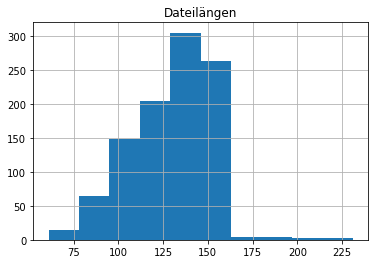

In [38]:
length_of_file = {}

counter_relocated=0

for f in os.listdir('../DATA/6_relocated'):
    os.remove(os.path.join('../DATA/6_relocated', f))

for file in os.listdir('../DATA/5_mirrored'):
    side = file[-5]
    df = pd.read_csv('../DATA/5_mirrored/'+file, sep = ';')              
    fileNumber = file.split("_mirrored",1)[0]
    relocated = pd.DataFrame(df.iloc[:,0]-df.iloc[0,0])
    relocated[df.columns.values[1]] = df.iloc[:,1]-df.iloc[0,1]
    relocated[df.columns.values[2]] = df.iloc[:,2]-df.iloc[0,2]
    relocated[df.columns.values[3]] = df.iloc[:,3]-df.iloc[0,0]
    relocated[df.columns.values[4]] = df.iloc[:,4]-df.iloc[0,1]
    relocated[df.columns.values[5]] = df.iloc[:,5]-df.iloc[0,2]
    relocated[df.columns.values[6]] = df.iloc[:,6]-df.iloc[0,0]
    relocated[df.columns.values[7]] = df.iloc[:,7]-df.iloc[0,1]
    relocated[df.columns.values[8]] = df.iloc[:,8]-df.iloc[0,2]          


    filename = '../DATA/6_relocated/'+str(fileNumber)+'_relocated_'+side+'.csv'
    relocated.to_csv(filename, sep = ';', float_format='%.4f', na_rep='NaN', index=False)
    length_of_file.update({filename:len(relocated)})
    counter_relocated+=1

print(str(counter_relocated)+" relocated")
pd.DataFrame({"Dateilängen": list(length_of_file.values())}).hist()

# 7. Metrikbasierte Filterung
Zunächst Einlesen der Dateien und Aufteilung in zwei Listen, in `r_files` für die rechte Körperhälfte und `l_files` für links.Außerdem Aufteilung in zwei Listen, in `r_files` für die rechte Körperhälfte und `l_files` für links.

In [74]:
r_files = []
l_files = []
all_files = []

for file in os.listdir('../DATA/6_relocated'):
    fileName = '../DATA/6_relocated/'+file
    if file.find("R") != -1:
        r_files.append(fileName)
    else:
        l_files.append(fileName)
    all_files.append(fileName)

print(str(len(r_files))+" right and "+str(len(l_files))+" left files found.")

586 right and 428 left files found.


## 7.1 Abstand Ellenbogen-Handgelenk
Berechnet für jeden Zeitpunkt den Abstand von Handgelenk und Ellenbogen und ermittelt die Mittelwerte dieser Abstände pro Datensatz. Da dieser Mittelwert von den anatomischen Gegebenheiten der Messperson abhängt, wird die Verteilung der Mittelwerte pro Messung in einem Histogramm visualisiert. 

In die Liste "elbow" werden die Dateien geschrieben, deren durchschnittlicher Ellenbogen-Handgelenk-Abstand größer oder kleiner eines Schwellwertes ist. Als Schwellwert wird nicht standardmäßig das 95 und 5 Quantil ver, sondern dynamisch von Standarbweichung des Datensatzes abhängend bestimmen. Grenzwert entspricht 1,5 % der Standarabweichung.
So werden nicht immer 10 % der Daten aussortiert, sondern je breiter die Verteilung, desto mehr.
Allerdings lässt dies nicht zwangsläufig den Schluss auf einen Sprung in den Handgelenksdaten zu, es können auch die Ellenbogendaten gestört sein.

### Statische Präfilterung
Ausreißer werden vorab entfernt, um die dynamische Schwellwertbildung und normierte Störungsstärke nicht zu verzerren. So fließen die Ausreißer maximal mit definierten Maximalwerten in die Normierung der anderen Werte mit ein, und nicht mit extrem hohen Werten.

603
411 extreme outlier files, 40.53 %


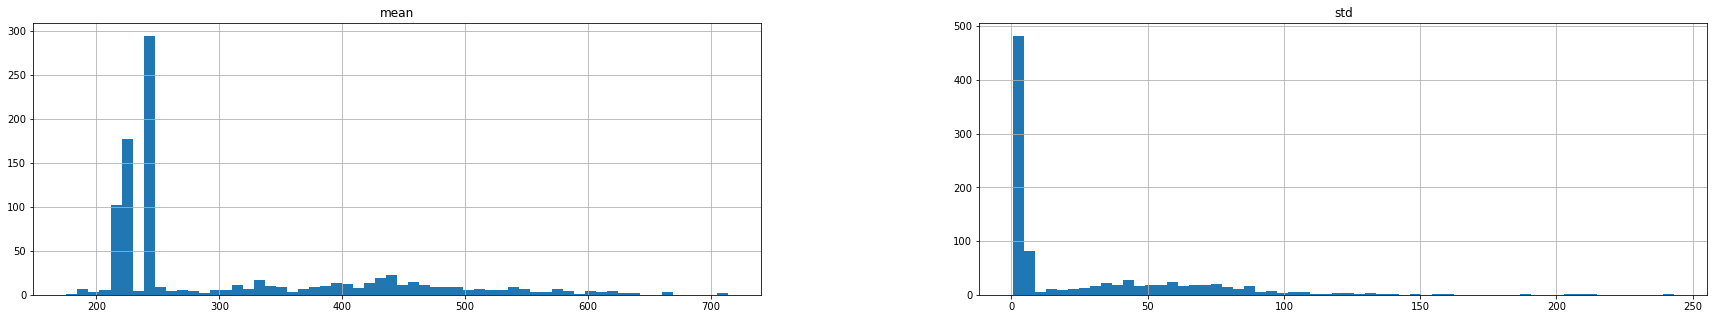

In [76]:
elbow_files_prefiltered = []
prefiltered = {
    "mean" : [],
    "std": []
}

outliers_prefiltered = {}

MAX_MEAN = 300
MAX_STD = 50

counter=0
for file in all_files:
    df = pd.read_csv(file, sep = ';')
    dist = []

    for index, row in df.iloc[:,[0,1,2,3,4,5]].iterrows():       
        dist.append(math.sqrt((row[0]-row[3])**2 + (row[1]-row[4])**2 + (row[2]-row[5])**2))
    series = pd.Series(dist)
    mean = series.mean()
    std = series.std()
    prefiltered["mean"].append(mean)
    prefiltered["std"].append(std)
    if mean < MAX_MEAN and std < MAX_STD:
        elbow_files_prefiltered.append(file)
    else:
        counter+=1
        outliers_prefiltered.update({file:1})
        
pd.DataFrame(prefiltered).hist(figsize=(30, 5), bins=60)
print(str(counter)+" extreme outlier files, "+str(round(100*counter/len(all_files),2))+" %")

20200305 std: 7.74 treshold: 0.061952283984518776 upper: 247.52377392532372 lower: 239.2603890408801
26 files, 12.38 %
20200403 std: 1.47 treshold: 0.011743552335285883 upper: 245.44095129635738 lower: 242.1085917061171
4 files, 3.77 %
20200423 std: 6.25 treshold: 0.04998288106158344 upper: 223.36390383961415 lower: 214.73905982292862
30 files, 10.45 %
Outliers: 471


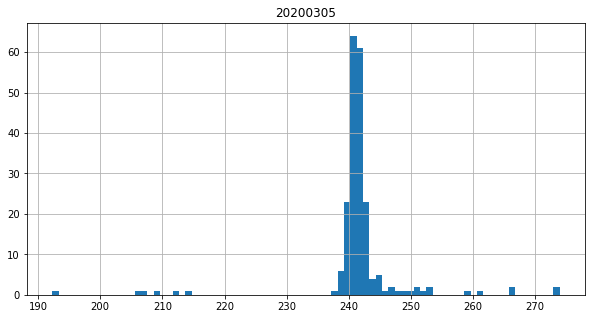

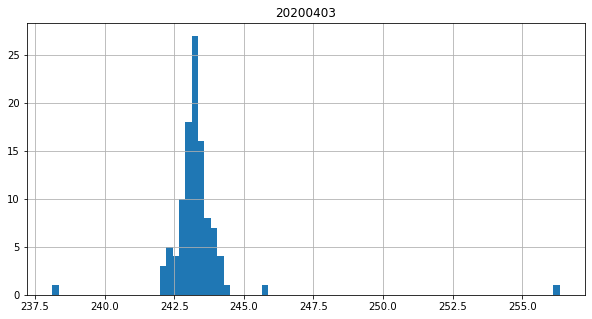

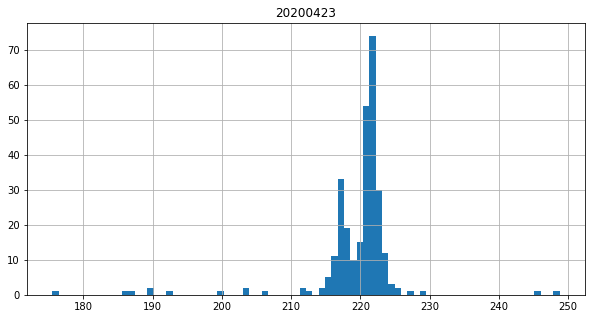

In [77]:
distances =  {}
thresholds = {}
outliers = {
    "elbow" : {},
    "hand":{},
    "otherHand_z": {}
}


FACTOR = 0.008


prevFileNumber = ''
for file in elbow_files_prefiltered:
    fileNumber = file[20:28]
    df = pd.read_csv(file, sep = ';')
    dist = []

    for index, row in df.iloc[:,[0,1,2,3,4,5]].iterrows():       
        dist.append(math.sqrt((row[0]-row[3])**2 + (row[1]-row[4])**2 + (row[2]-row[5])**2))
    mean = pd.Series(dist).mean()
    
    if fileNumber != prevFileNumber:
        distances.update({fileNumber:{}})
    distances[fileNumber].update({file:mean})
    prevFileNumber = fileNumber
    
for key in distances.keys():
    df_distances = pd.DataFrame({key: list(distances[key].values())})
    df_distances.hist(figsize=(10, 5), bins=80)
    threshold_value = df_distances.std()[0] * FACTOR
    if threshold_value >0.5:
        threshold_value = 0.5
        print("ERROR STD TO LARGE!")
    upper_bound = df_distances.quantile(q=(1-threshold_value))[0]
    lower_bound = df_distances.quantile(q=threshold_value)[0]
    thresholds.update({key:[lower_bound, upper_bound]})
    print(key+" std: "+str(round(df_distances.std()[0],2))+" treshold: "+str(threshold_value)+" upper: "+str(upper_bound)+" lower: "+str(lower_bound))
    
    counter=0
    for index, value in df_distances.iterrows():
        if value[0] < lower_bound or value[0] > upper_bound:
            counter+=1       
    print(str(counter) + " files, "+ str(round(100*counter/len(distances[key]),2))+" %")

idx = 0
for file in elbow_files_prefiltered:
    fileNumber = file[20:28]
    if distances[fileNumber][file] > thresholds[fileNumber][1] or distances[fileNumber][file] < thresholds[fileNumber][0]:
        meanOfAllValues = pd.DataFrame(distances[key].values()).mean()[0]
        distanceToMean = abs(meanOfAllValues - distances[fileNumber][file])
        outliers["elbow"].update({file:distanceToMean})
    idx+=1
    
normalized_values = list(outliers["elbow"].values())
max_normalized_value = max(normalized_values)
min_normalized_value = min(normalized_values)
for filePath in list(outliers["elbow"].keys()):
    outliers["elbow"][filePath] = (outliers["elbow"][filePath]-min_normalized_value)/(max_normalized_value-min_normalized_value)
    
for filePath in list(outliers_prefiltered.keys()):
    outliers["elbow"].update({filePath:outliers_prefiltered[filePath]})
    
print("Outliers: "+str(len(outliers["elbow"])))

## 7.2 Handgelenkvergleich
Berechnet zunächst pro Messdurchlauf die durchschnittlichen Handabstände, diese variieren naturgemäß, da während der Bewegung die Hände sich voneinander entfernen. Dennoch lassen sich über die Mitterlwerte Ausreißer identifzieren. Die Grenze für Ausreißer wird dynamisch pro Messdurchlauf definiert, sie hängt von der Standardabweichung des Durchlaufs ab.

Außerdem wird die Differenz der z-Koordinaten für die Trajektorien von linker und rechter Hand gebildet, diese sollte weitesgehend 0 sein, sofern sich die Hände gleichzeitig hoch/runter bewegen. Größere Abweichungen zeigen Ausreißer an. Auch hier dynamische Schwellwertdefinition

Generell könnten auch noch x,y Koordinaten verglichen werden, liegen aber in Ursprungsdaten noch nicht in einer Ebene. Transformation notwendig.

=> Sprünge können aber auch in für uns nicht relevanten linken Hand vorkommen.


Problem: Datensätze haben unterschiedliche Länge, sollten davor noch zugeschnitten werden

### Statische Präfilterung

12 extreme outlier files, 1.55 %


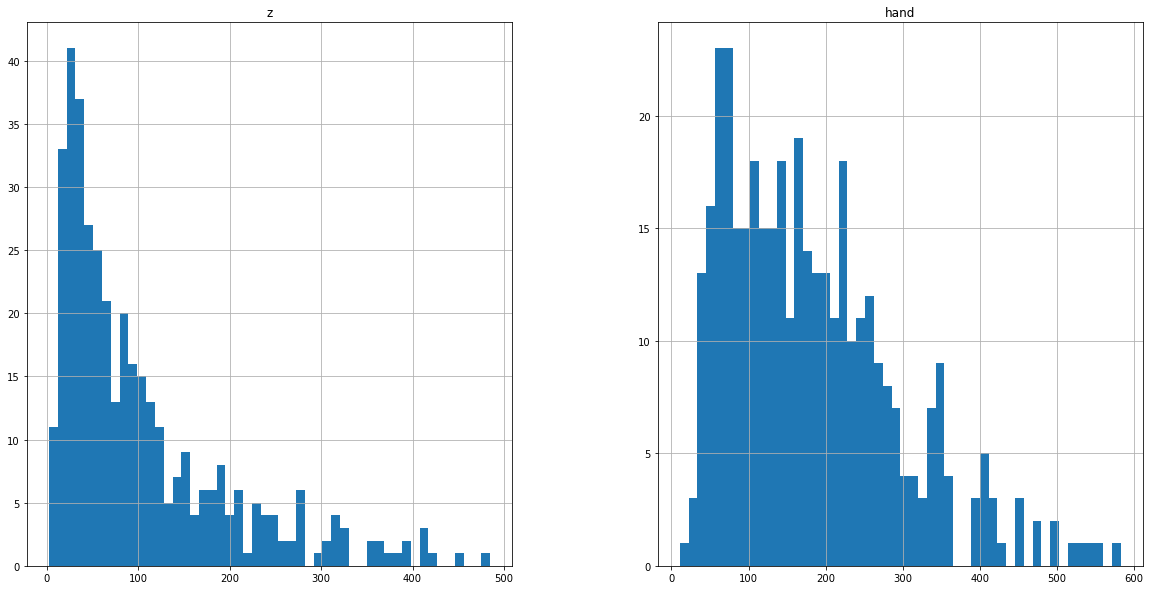

In [78]:
hand_files_prefiltered = []
prefiltered = {
    "z":[],
    "hand":[]
}
outliers_prefiltered = {
    "otherHand_z":{},
    "hand":{}
}

MAX_Z = 400
MAX_HAND = 600
count_r_with_l = 0

for file in r_files:
    startOfFile = file.split("R",1)[0]
    pathOfOtherFile = startOfFile + 'L.csv'

    if os.path.isfile(pathOfOtherFile):
        side1 = pd.read_csv(file, sep = ';').iloc[:,[0,1,2]]
        side2 = pd.read_csv(pathOfOtherFile, sep = ';').iloc[:,[0,1,2]]
        count_r_with_l +=2
                
        x_diff = []
        y_diff = []
        z_diff = []
        hands = []
        idx = 0
        while idx<(len(side1)-1) and idx<(len(side2)-1):
            y_diff.append(abs(side1.iloc[idx,1]-side2.iloc[idx,1]))
            z_diff.append(abs(side1.iloc[idx,2]-side2.iloc[idx,2]))
            x_diff.append(abs(side1.iloc[idx,0]-side2.iloc[idx,0]))
            hands.append(math.sqrt((side1.iloc[idx,0]-side2.iloc[idx,0])**2 + (side1.iloc[idx,1]-side2.iloc[idx,1])**2 + (side1.iloc[idx,2]-side2.iloc[idx,2])**2))
            idx+=1
        z_mean = pd.Series(z_diff, dtype="float64").mean()
        hand_mean = pd.Series(hands, dtype="float64").mean()
        prefiltered["z"].append(z_mean)
        prefiltered["hand"].append(hand_mean)
        
        if z_mean < MAX_Z and hand_mean < MAX_HAND:
            hand_files_prefiltered.append(file)
            hand_files_prefiltered.append(pathOfOtherFile)
        elif z_mean >= MAX_Z:
            outliers_prefiltered["otherHand_z"].update({file:1})
            outliers_prefiltered["otherHand_z"].update({pathOfOtherFile:1})
        elif hand_mean >= MAX_HAND:
            outliers_prefiltered["hand"].update({file:1})
            outliers_prefiltered["hand"].update({pathOfOtherFile:1})
pd.DataFrame(prefiltered).hist(figsize=(20, 10), bins=50)    

outliers_count = count_r_with_l - len(hand_files_prefiltered)
print(str(outliers_count)+" extreme outlier files, "+str(round(100*outliers_count/count_r_with_l,2))+" %")

20200305 hand upper: 347.95013100430384, hand lower: 45.64898398044139, z upper: 189.07772734374998
20 hand files, 12 z files
D:\Programme\Anaconda\envs\Vorlesung\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
20200403 hand upper: 387.6627500960384, hand lower: 26.73548471816388, z upper: 254.02892086381203
4 hand files, 2 z files
D:\Programme\Anaconda\envs\Vorlesung\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
20200423 hand upper: 355.71468855823963, hand lower: 50.48711279852318, z upper: 273.5286567340006
52 hand files, 36 z files
hand: 76, z: 6

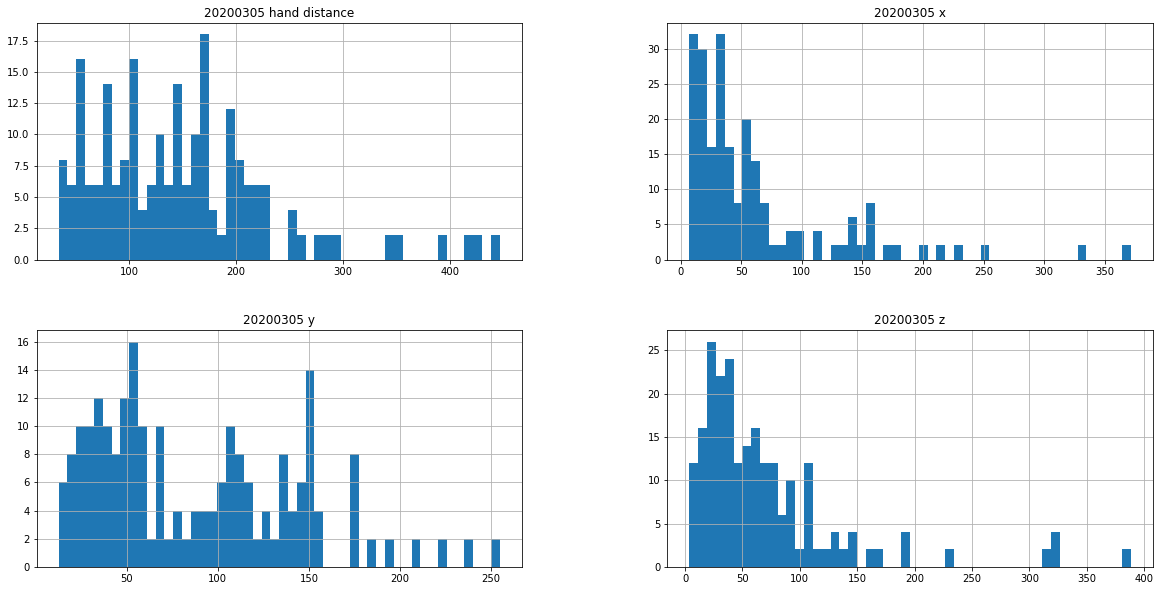

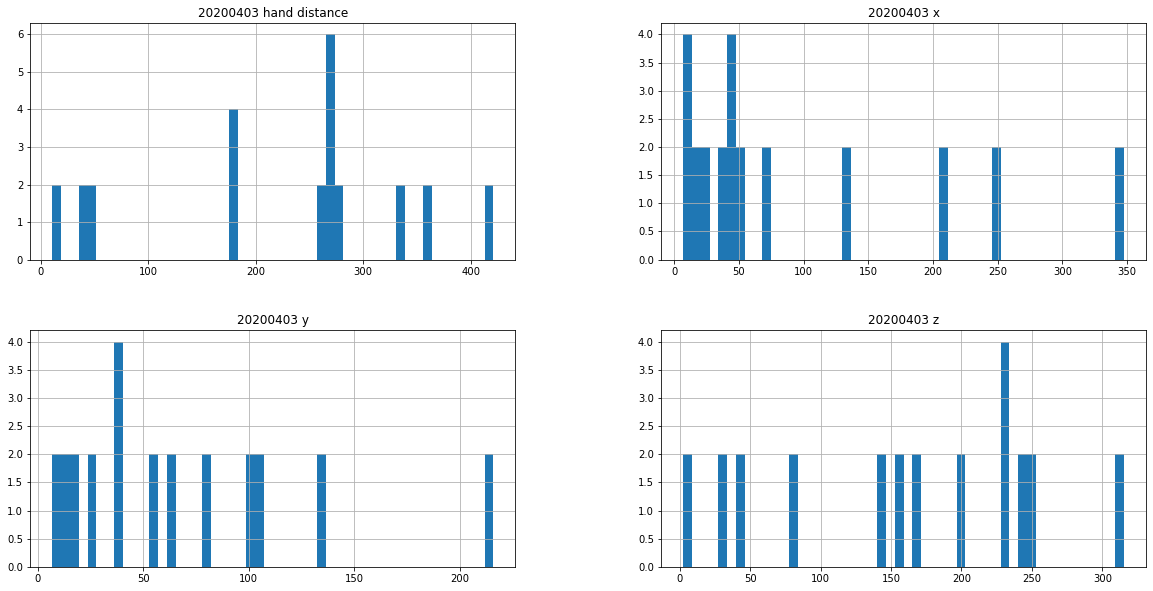

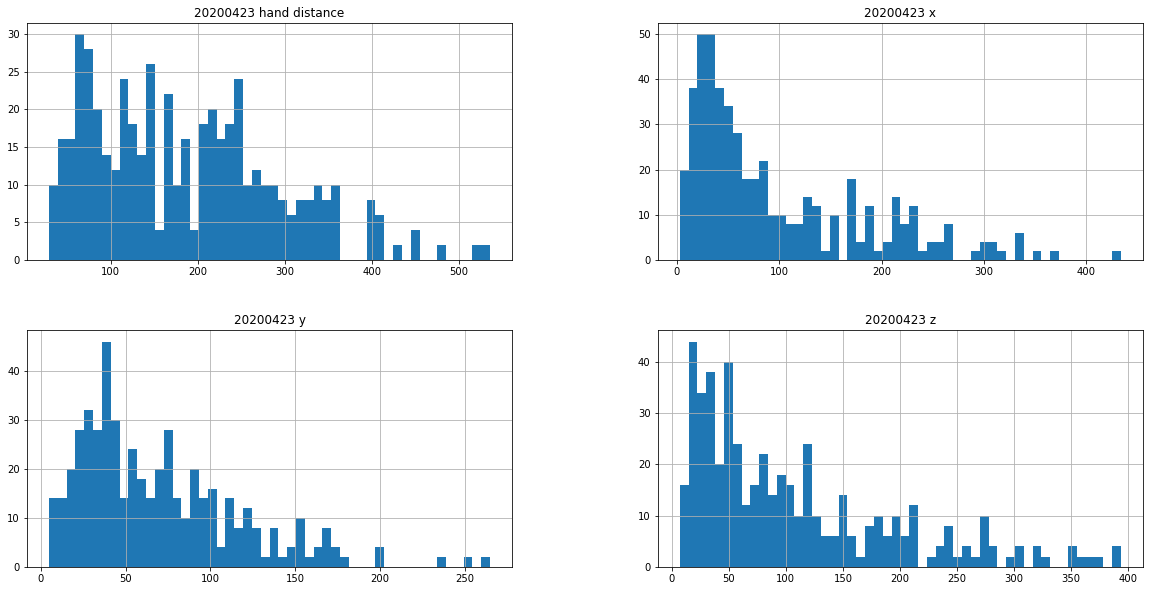

In [79]:
differences = {
    "x":{},
    "y":{},
    "z":{},
    "hands":{}
}
threshold = {
    "x" : 0,
    "y" : 0,
    "z" : {},
    "hands" : {}
}
outliers["otherHand_z"].clear()
outliers["hand"].clear()

r_with_l = []

FACTOR = 0.0005
FACTOR_Z = 0.0008

prevFileNumber = ''
for file in hand_files_prefiltered:  #contains only right sides
    fileNumber = file[20:28]
    startOfFile = file.split("R",1)[0]
    pathOfOtherFile = startOfFile + 'L.csv'
    if os.path.isfile(pathOfOtherFile):
        r_with_l.append(file)
        r_with_l.append(pathOfOtherFile)
        side1 = pd.read_csv(file, sep = ';').iloc[:,[0,1,2]]
        side2 = pd.read_csv(pathOfOtherFile, sep = ';').iloc[:,[0,1,2]]
                
        x_diff = []
        y_diff = []
        z_diff = []
        hands = []
        idx = 0
        while idx<(len(side1)-1) and idx<(len(side2)-1):
            y_diff.append(abs(side1.iloc[idx,1]-side2.iloc[idx,1]))
            z_diff.append(abs(side1.iloc[idx,2]-side2.iloc[idx,2]))
            x_diff.append(abs(side1.iloc[idx,0]-side2.iloc[idx,0]))
            hands.append(math.sqrt((side1.iloc[idx,0]-side2.iloc[idx,0])**2 + (side1.iloc[idx,1]-side2.iloc[idx,1])**2 + (side1.iloc[idx,2]-side2.iloc[idx,2])**2))
            idx+=1
        if fileNumber != prevFileNumber:
            differences["hands"].update({fileNumber:{}})
            differences["x"].update({fileNumber:{}})
            differences["y"].update({fileNumber:{}})
            differences["z"].update({fileNumber:{}})
        differences["hands"][fileNumber].update({file:pd.Series(hands, dtype="float64").mean()})
        differences["x"][fileNumber].update({file:pd.Series(x_diff, dtype="float64").mean()})
        differences["y"][fileNumber].update({file:pd.Series(y_diff, dtype="float64").mean()})
        differences["z"][fileNumber].update({file:pd.Series(z_diff, dtype="float64").mean()})
        differences["hands"][fileNumber].update({pathOfOtherFile:pd.Series(hands, dtype="float64").mean()})
        differences["x"][fileNumber].update({pathOfOtherFile:pd.Series(x_diff, dtype="float64").mean()})
        differences["y"][fileNumber].update({pathOfOtherFile:pd.Series(y_diff, dtype="float64").mean()})
        differences["z"][fileNumber].update({pathOfOtherFile:pd.Series(z_diff, dtype="float64").mean()})
        prevFileNumber = fileNumber

for fileNumber in differences["hands"].keys():
    hand_distances_key = fileNumber+" hand distance"
    z_key = fileNumber + " z"
    df= pd.DataFrame({
        hand_distances_key : list(differences["hands"][fileNumber].values()),
        fileNumber+" x" : list(differences["x"][fileNumber].values()),
        fileNumber+" y" : list(differences["y"][fileNumber].values()),
        z_key : list(differences["z"][fileNumber].values())
    })
    df.hist(figsize=(20, 10), bins=50)    
    threshold_value = df.loc[:,hand_distances_key].std() * FACTOR
    upper_bound = df.loc[:,hand_distances_key].quantile(q=(1-threshold_value))
    lower_bound = df.loc[:,hand_distances_key].quantile(q=threshold_value)
    threshold["hands"].update({fileNumber:[lower_bound, upper_bound]})
    threshold_value = df.loc[:,z_key].std() * FACTOR_Z
    upper_bound_z = df.loc[:,z_key].quantile(q=(1-threshold_value))
    threshold["z"].update({fileNumber:upper_bound_z})
    print(fileNumber+" hand upper: "+str(upper_bound)+", hand lower: "+str(lower_bound)+", z upper: "+str(upper_bound_z))

    counter=0
    for val in df.loc[:,hand_distances_key].lt(lower_bound):
        if val:
            counter+=1
    for val in df.loc[:,hand_distances_key].gt(upper_bound):
        if val:
            counter+=1
    counter_z=0
    for val in df.loc[:,z_key].gt(upper_bound_z):
        if val:
            counter_z+=1
    print(str(counter) + " hand files, "+str(counter_z)+" z files")

for file in r_with_l:
    fileNumber = file[20:28]
    if differences["hands"][fileNumber][file] > threshold["hands"][fileNumber][1] or differences["hands"][fileNumber][file] < threshold["hands"][fileNumber][0]:
        meanOfAllValues = pd.DataFrame(differences["hands"][fileNumber].values()).mean()[0]
        distanceToMean = abs(meanOfAllValues - differences["hands"][fileNumber][file])
        outliers["hand"].update({file:distanceToMean})
    if differences["z"][fileNumber][file] > threshold["z"][fileNumber]:
        meanOfAllValues = pd.DataFrame(differences["z"][fileNumber].values()).mean()[0]
        distanceToMean = abs(meanOfAllValues - differences["z"][fileNumber][file])
        outliers["otherHand_z"].update({file:distanceToMean})

normalized_values = list(outliers["hand"].values())
max_normalized_value = max(normalized_values)
min_normalized_value = min(normalized_values)
for fileNumber in list(outliers["hand"].keys()):
    outliers["hand"][fileNumber] = (outliers["hand"][fileNumber]-min_normalized_value)/(max_normalized_value-min_normalized_value)

normalized_values = list(outliers["otherHand_z"].values())
max_normalized_value = max(normalized_values)
min_normalized_value = min(normalized_values)
for fileNumber in list(outliers["otherHand_z"].keys()):
    outliers["otherHand_z"][fileNumber] = (outliers["otherHand_z"][fileNumber]-min_normalized_value)/(max_normalized_value-min_normalized_value)
    
for file in list(outliers_prefiltered["otherHand_z"].keys()):
    outliers["otherHand_z"].update({file:outliers_prefiltered["otherHand_z"][file]})
for file in list(outliers_prefiltered["hand"].keys()):
    outliers["hand"].update({file:outliers_prefiltered["hand"][file]})
    
print("hand: "+str(len(outliers["hand"]))+", z: "+str(len(outliers["otherHand_z"])))

## 6.3 Schnittmenge
Welche Daten aussortieren? Vereinigung aller Ausreißer? Wenn Datei bei mind. zwei Ausreißern dabei ist? Dabei sind Ausreißer bei Hand- und Ellbogenabständen stärker zu gewichten. Din Ellbogenabstandausreißer und Auffälligkeiten im Vergleich zur anderen Hand lassen auf eine Störung der Handdaten schließen. 
Handabstände auch mit 3 gewichten??

Zu jedem Art Ausreißer werden zudem noch die normalized_values erfasst, die die Stärke des Ausreißer quantifizieren sollen. Sie stellen das Verhältnis des Abstands zum Mittelwert des Messdurchlaufs zum Mitelwert selbst dar und werden auf das Intervall 0-1 normiert.

Broken files werden in den 99_broken Ordner geschrieben, im csv wird die Headerzeile durch eine Begründung der Aussortierung ergänzt. Angegeben werden die normierten Werte der Stärke der Ausreißer für z-Koordinate, Handabstände und Ellenbogenabstände.

4.776159494217119
Broken: 185


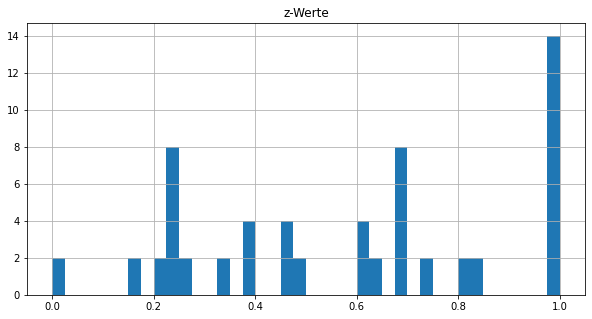

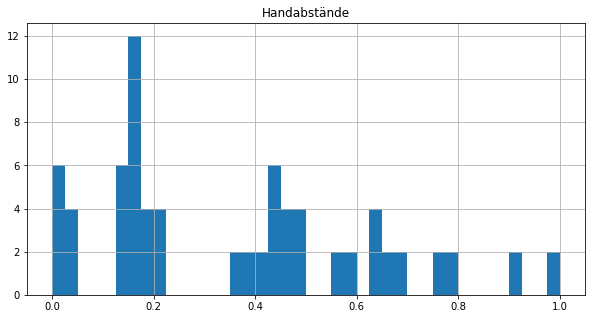

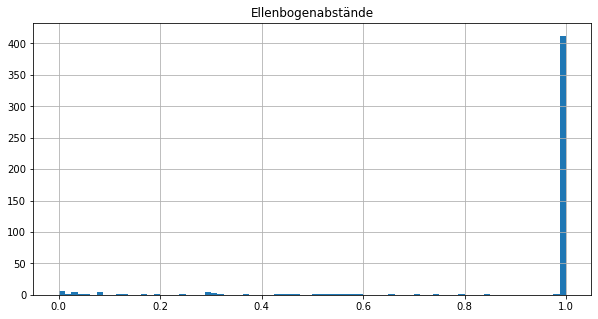

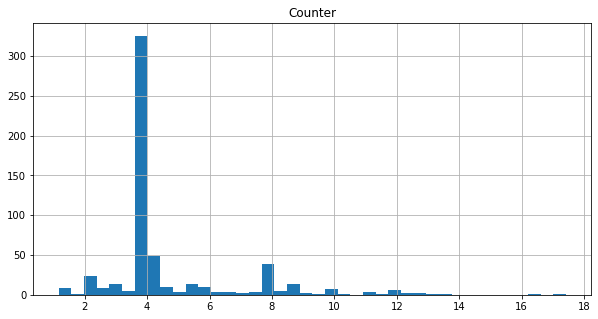

In [87]:
intersec = [value for value in list(outliers["hand"].keys()) if value in list(outliers["elbow"].keys()) ]
union = list(set().union(list(outliers["otherHand_z"].keys()),list(outliers["hand"].keys()),list(outliers["elbow"].keys())))

broken_files = {}
pd.DataFrame({"z-Werte":list(outliers["otherHand_z"].values())}).hist(figsize=(10,5),bins=40)
pd.DataFrame({"Handabstände":list(outliers["hand"].values())}).hist(figsize=(10,5),bins=40)
pd.DataFrame({"Ellenbogenabstände":list(outliers["elbow"].values())}).hist(figsize=(10,5),bins=80)


#manual labeled files
with open('manual_labeling/bad_files.csv') as f:
    lines = f.readlines()
manual_labeled_bad_files = [x.strip() for x in lines]
manual_labeled_bad_files = [x.replace("raw","relocated") for x in manual_labeled_bad_files]
manual_labeled_bad_files = ['../DATA/6_relocated/'+x for x in manual_labeled_bad_files]

manual_broken = []
for file in manual_labeled_bad_files:
    if os.path.exists(file):
        manual_broken.append(file)


counters = []

for file in all_files:
    counter = 0
    outlier_value_z = 0
    outlier_value_hand = 0
    outlier_value_elbow = 0
    isManualBroken=False
    if file in list(outliers["otherHand_z"].keys()):
        outlier_value_z = outliers["otherHand_z"][file]
        counter+=1+outlier_value_z
    if file in list(outliers["hand"].keys()):
        outlier_value_hand = outliers["hand"][file]
        counter+=4*(1+outlier_value_hand)
    if file in list(outliers["elbow"].keys()):
        outlier_value_elbow = outliers["elbow"][file]
        counter+=2*(1+outlier_value_elbow)
    if file in manual_broken:
        isManualBroken =True
        counter+=4.01
    if counter != 0:
        counters.append(counter)
    if counter > 4:
        broken_files.update({file:[outlier_value_z, outlier_value_hand, outlier_value_elbow, isManualBroken]})

df = pd.DataFrame({"Counter":counters})
df.hist(figsize=(10,5),bins=40)
print(df.mean()[0])

print("Broken: "+str(len(broken_files.keys())))

for f in os.listdir('../DATA/7_filtered'):
    os.remove(os.path.join('../DATA/7_filtered', f))
for f in os.listdir('../DATA/99_broken'):
    os.remove(os.path.join('../DATA/99_broken', f))

folder = '../DATA/6_relocated/'
for file in os.listdir('../DATA/6_relocated'):
    side = file[-5]
    fileNumber = file.split("_relocated",1)[0]
    if folder+file in broken_files.keys():
        z_value = round(broken_files[folder+file][0],3)
        hand_value = round(broken_files[folder+file][1],3)
        elbow_value = round(broken_files[folder+file][2],3)
        is_manual_broken = broken_files[folder+file][3]
        
        broken_file = open(folder+file,'r')
        appended_file = open('../DATA/99_broken/'+str(fileNumber)+'_broken_'+side+'.csv','w')
        broken_content = broken_file.readlines()
        appended_file.write('z-difference='+str(z_value)+', hand-distance='+str(hand_value)+', elbow-hand-distance='+str(elbow_value)+', manual broken:'+str(is_manual_broken)+'\n')
        for line in broken_content:
            if line == broken_content[0]:
                continue
            appended_file.write(line)
        broken_file.close()
        appended_file.close()
    else:
        shutil.copyfile(folder+file,'../DATA/7_filtered/'+str(fileNumber)+'_filtered_'+side+'.csv')

# 8. Rotation

Trajektorien werden so rotiert, dass ein Midpoint auf der x-Achse liegt. Dieser ist z.B. der 80. Punkt der Bewegung. 
Rotationsachse: Normale der vom Ortsvektor des Midpoints und der x-Achse aufgespannten Ebene
Rotationswinkel: Winkel zwischen Ortsvektor des Midpoints und x-Achse
Rotation erfolgt über Drehmatrix (Koordinatentransformation), diese benötigt einen normierten Vektor als Drehachse und den Drehwinkel in Bogenmaß.

Der Ortsvektor der ursprünglichen Trajektorie wird zur Retransformation in die erste Zeile der CSV-Datei geschrieben.

In [81]:
from math import cos, sin

MID_POINT = 80

for f in os.listdir('../DATA/8_rotated'):
    os.remove(os.path.join('../DATA/8_rotated', f))

for file in os.listdir('../DATA/7_filtered'):
    fileNumber = file.split("_filtered",1)[0]
    side = file[-5]
    df = pd.read_csv('../DATA/7_filtered/'+file, sep = ';')  
    if len(df) > 79:
        mid_point = df.iloc[(MID_POINT-1),[0,1,2]] #get midpoint
        cos_val = mid_point.iloc[0] / (math.sqrt(mid_point.iloc[0]**2+mid_point.iloc[1]**2+mid_point.iloc[2]**2)) #get angle to x-axis
        a = math.acos(cos_val)

        mid_point_vec = np.array([[mid_point.iloc[0]],[mid_point.iloc[1]],[mid_point.iloc[2]]])
        x_vec = np.array([[1],[0],[0]])
        norm_vec = np.cross(mid_point_vec, x_vec, axis=0) #get normal vector of plane

        n = np.divide(norm_vec, np.linalg.norm(norm_vec)) #normalize vector

        transform_mat = np.array([[n[0]**2*(1-cos(a))+cos(a),        n[0]*n[1]*(1-cos(a))-n[2]*sin(a), n[0]*n[2]*(1-cos(a))+n[1]*sin(a)],
                                  [n[1]*n[0]*(1-cos(a))+n[2]*sin(a), n[1]**2*(1-cos(a))+cos(a),        n[1]*n[2]*(1-cos(a))-n[0]*sin(a)],
                                  [n[2]*n[0]*(1-cos(a))-n[1]*sin(a), n[2]*n[1]*(1-cos(a))+n[0]*sin(a), n[2]**2*(1-cos(a))+cos(a)       ]])
        transform_mat = transform_mat.reshape((3,3))
        transformed_points = np.empty((0,3), float)

        rotated_file = open('../DATA/8_rotated/'+fileNumber+'_rotated_'+side+'.csv','w')
        rotated_file.write(f"##mid_point_vec:{mid_point.iloc[0]};{mid_point.iloc[1]};{mid_point.iloc[2]}\n")

        idx = 0
        while idx<len(df):
            point = np.array([[df.iloc[idx,0]],[df.iloc[idx,1]],[df.iloc[idx,2]]])
            transformed_point = np.matmul(transform_mat, point)
            transformed_point = np.transpose(transformed_point)
            transformed_points = np.append(transformed_points, transformed_point, axis=0)
            idx+=1

        np.savetxt(rotated_file, transformed_points, fmt='%.4f', delimiter=';')
        rotated_file.close()

# Sonstiger Code

## Abgleich mit manuell gelabelten Daten

In [88]:
with open('manual_labeling/bad_files.csv') as f:
    manual_labeled_bad_files = f.readlines()
manual_labeled_bad_files = [x.strip() for x in manual_labeled_bad_files] 
prefiltered_files = []
filtered_files = []
len_bad_files = len(manual_labeled_bad_files)
prefilteredCounter = 0
filteredCounter = 0
manPrefilteredCounter = 0
manFilteredCounter = 0

manualButNotFiltered = open('manual_labeling/manual_but_not_automatic.csv','w')
filteredButNotManual = open('manual_labeling/automatic_but_not_manual.csv','w')

for file in os.listdir('../DATA/98_broken_prefiltered'):
    fileNumber = file.split("_broken",1)[0]
    side = file[-5]
    fileName = fileNumber + '_raw_' +side+'.csv'
    prefiltered_files.append(fileName)
    if fileName in manual_labeled_bad_files:
        prefilteredCounter += 1
    else:
        filteredButNotManual.write(fileName+'\n')

for file in os.listdir('../DATA/99_broken'):
    fileNumber = file.split("_broken",1)[0]
    side = file[-5]
    fileName = fileNumber + '_raw_' +side+'.csv'
    filtered_files.append(fileName)
    if fileName in manual_labeled_bad_files:
        filteredCounter += 1
    else:
        filteredButNotManual.write(fileName+'\n')

for file in manual_labeled_bad_files:
    if file in prefiltered_files:
        manPrefilteredCounter+=1
    if file in filtered_files:
        manFilteredCounter+=1
    if file not in prefiltered_files and file not in filtered_files:
        manualButNotFiltered.write(file+'\n')

percentagePrefiltered = round(100*prefilteredCounter/len_bad_files,2)
percentageFiltered = round(100*filteredCounter/len_bad_files,2)
percentageManPrefilterd = round(100*manPrefilteredCounter/len(prefiltered_files),2)
percentageManFiltered = round(100*manFilteredCounter/len(filtered_files),2)

manualButNotFiltered.close()
filteredButNotManual.close()

print(f"{percentagePrefiltered}% der manuell aussortierten Dateien ({prefilteredCounter}/{len_bad_files}) wurden auch präfiltert")
print(f"{percentageFiltered}% der manuell aussortierten Dateien ({filteredCounter}/{len_bad_files}) wurden auch gefiltert")
print("--------------")
print(f"{percentageManPrefilterd}% der präfilterten Dateien ({manPrefilteredCounter}/{len(prefiltered_files)}) wurden auch manuell aussortiert")
print(f"{percentageManFiltered}% der gefilterten Dateien ({manFilteredCounter}/{len(filtered_files)}) wurden auch manuell aussortiert")


62.55% der manuell aussortierten Dateien (157/251) wurden auch präfiltert
40.24% der manuell aussortierten Dateien (101/251) wurden auch gefiltert
--------------
89.71% der präfilterten Dateien (157/175) wurden auch manuell aussortiert
54.59% der gefilterten Dateien (101/185) wurden auch manuell aussortiert


## Geschwindigkeitsstatistik

array([[<AxesSubplot:title={'center':'max_hand'}>,
        <AxesSubplot:title={'center':'mean_hand'}>],
       [<AxesSubplot:title={'center':'max_elbow'}>,
        <AxesSubplot:title={'center':'mean_elbow'}>]], dtype=object)

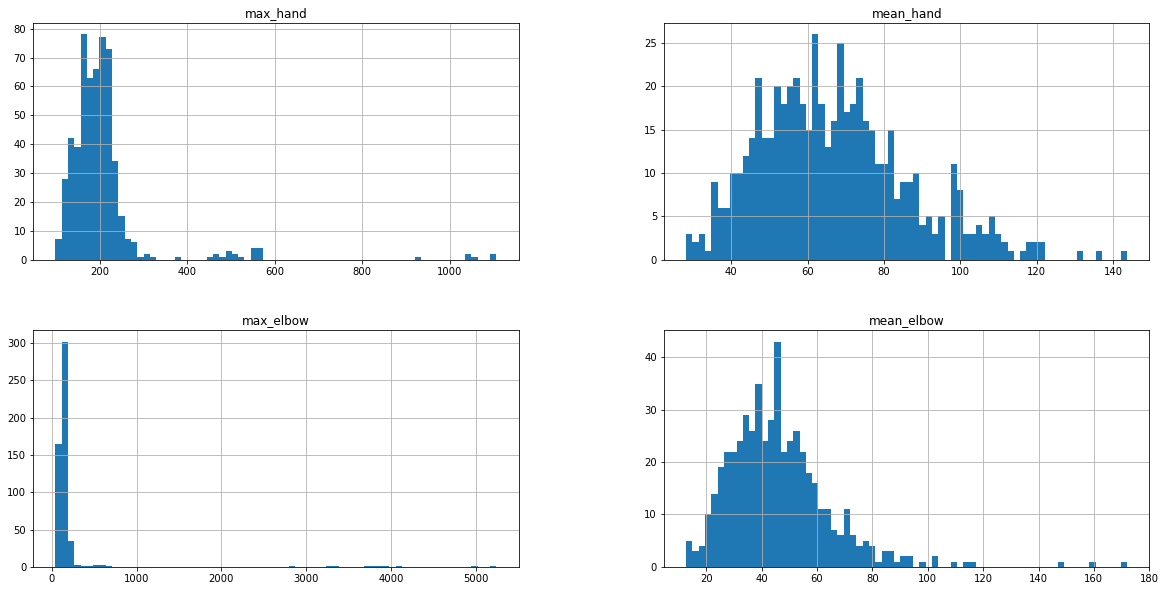

In [6]:
velo_stats = {
    "max_hand":[],
    "mean_hand":[],
    "max_elbow":[],
    "mean_elbow":[]
}


for file in r_files:
    df = pd.read_csv(file, sep = ';')
    v_df = np.gradient(df, axis=0)
    velos_hand = np.sqrt(np.square(v_df[:,0])+np.square(v_df[:,1])+np.square(v_df[:,2]))
    velos_elbow = np.sqrt(np.square(v_df[:,3])+np.square(v_df[:,4])+np.square(v_df[:,5]))
    velo_stats["max_hand"].append(np.max(velos_hand)*12)
    velo_stats["mean_hand"].append(np.mean(velos_hand)*12)
    velo_stats["max_elbow"].append(np.max(velos_elbow)*12)
    velo_stats["mean_elbow"].append(np.mean(velos_elbow)*12)

pd.DataFrame(velo_stats).hist(figsize=(20, 10), bins=70)

## NaN-Statistik

Zählt die NaN-Werte pro Datei im Ordner data und gibt die Anzahl der Dateien ohne NaN, mit bis zu 10 NaN oder mehr als 10 NaN aus. Die Dateinamen werden jeweils im Dictionary `files_list` in die entsprechende Liste hinzugefügt.   
Es werden nur die Handgelenkdaten berücksichtigt.

In [ ]:
files_list = {
    "withoutNaN" : [],
    "atleast1NaN" : [],
    "morethan10NaN": [],
    "worthToInterpolate": []
}

for file in os.listdir('./data'):
    if file.find("RGrasp") != -1:
        df = pd.read_csv('./data/'+file, sep = ';')
        wjc = df.iloc[:,[0,1,2]]
        nans_sum = wjc.isna().sum().sum()

        if nans_sum == 0:
            files_list["withoutNaN"].append(file)
        elif nans_sum >= 1:
            files_list["atleast1NaN"].append(file)
        if nans_sum > 10:
            files_list["morethan10NaN"].append(file)

print("Files without NaN: "+str(len(files_list["withoutNaN"])))
print("Files with at least 1 NaN: "+str(len(files_list["atleast1NaN"])))
print("Files with more than 10 NaN: "+str(len(files_list["morethan10NaN"])))

### Zeichnet Histogramm über die Längen der NaN-Folgen in jeder Koordinate

In [ ]:
NaN_occurences = {
    "x":[],
    "y":[],
    "z":[]
}

counter = {
    "x":0,
    "y":0,
    "z":0
}

for file in files_list["atleast1NaN"]:
    df = pd.read_csv('./data/'+file, sep = ';')  
    wjc = df.iloc[:,[0,1,2]]
    
    for index,row in wjc.iterrows():
        if math.isnan(row[0]):
            counter["x"]+=1
        else:
            if counter["x"]!=0:
                NaN_occurences["x"].append(counter["x"])
                counter["x"]=0
                
        if math.isnan(row[1]):
            counter["y"]+=1
        else:
            if counter["y"]!=0:
                NaN_occurences["y"].append(counter["y"])
                counter["y"]=0
        
        if math.isnan(row[2]):
            counter["z"]+=1
        else:
            if counter["z"]!=0:
                NaN_occurences["z"].append(counter["z"])
                counter["z"]=0

    counter["x"] = 0
    counter["y"] = 0
    counter["z"] = 0

nans_df = pd.DataFrame(NaN_occurences)

nans_df.hist(figsize=(20,10), bins=80)
nans_df.describe()

### Fügt nach Festlegung eines Schwellwertes in "worthToInterpolate"-Liste alle Dateinamen hinzu, die maximal soviele direkt aufeinanderfolgende NaNs haben

In [ ]:
counter = {
    "x":0,
    "y":0,
    "z":0
}
threshold = 2
files_list["worthToInterpolate"].clear()

for file in files_list["atleast1NaN"]:
    df = pd.read_csv('./data/'+file, sep = ';')  
    wjc = df.iloc[:,[0,1,2]]
    
    row = 0
    while counter["x"] <= threshold and counter["y"] <= threshold and counter["z"] <= threshold:
        if math.isnan(wjc.iloc[row,0]):
            counter["x"]+=1
        if math.isnan(wjc.iloc[row,1]):
            counter["y"]+=1
        if math.isnan(wjc.iloc[row,2]):
            counter["z"]+=1
        if row == (len(wjc)-1):
            files_list["worthToInterpolate"].append(file)
            break
        else:
            row+=1
    counter["x"] = 0
    counter["y"] = 0
    counter["z"] = 0


print("Files with max. "+str(threshold)+" NaNs in a row: "+str(len(files_list["worthToInterpolate"])))

print(files_list["worthToInterpolate"])

## Startpunkte analysieren
Visualisiert die verschiedenen Startkoordinaten für x, y und z in drei Histogrammen sowie berechnet statistische Größen (für die rechte Hand).

Ausreißer: 20200423006_takeover_RGraspPhase.csv, 20200305163_takeover_RGraspPhase.csv (z)

Mehrere Hügel durch mehrere Messdurchläufe?

In [ ]:
starts = {
    "x": [],
    "y": [],
    "z": []
}

for file in files_list["withoutNaN"]:
    df = pd.read_csv('./data/'+file, sep = ';')
    starts["x"].append(df.iloc[0,0])
    starts["y"].append(df.iloc[0,1])
    starts["z"].append(df.iloc[0,2])
    
ser = pd.DataFrame(starts)
ser.hist(figsize=(20, 10), bins=50)

ser.describe()